<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reverse-Engineering-Google-pay's-'Tez-mode'." data-toc-modified-id="Reverse-Engineering-Google-pay's-'Tez-mode'.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reverse Engineering Google pay's <font color="green">'Tez mode'.</font></a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Funtions-to-upsample-and-'sinc'-interpolate" data-toc-modified-id="Funtions-to-upsample-and-'sinc'-interpolate-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Funtions to upsample and 'sinc' interpolate</a></span></li><li><span><a href="#Extracting-the-baseband-signal-and-loading-it-into-python." data-toc-modified-id="Extracting-the-baseband-signal-and-loading-it-into-python.-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Extracting the baseband signal and loading it into python.</a></span></li><li><span><a href="#Construct-DSSS-binary-code-sequence-and-code-signal" data-toc-modified-id="Construct-DSSS-binary-code-sequence-and-code-signal-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Construct DSSS binary code sequence and code-signal</a></span></li><li><span><a href="#DSSS-code-synchronization-(i.e.-cross-correlation-of-code-signal-with-our-baseband-signal)" data-toc-modified-id="DSSS-code-synchronization-(i.e.-cross-correlation-of-code-signal-with-our-baseband-signal)-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>DSSS code synchronization (i.e. cross-correlation of code-signal with our baseband signal)</a></span></li><li><span><a href="#Find-the-first-largest-correlation-peak." data-toc-modified-id="Find-the-first-largest-correlation-peak.-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>Find the first largest correlation peak.</a></span></li><li><span><a href="#DSSS-code-tracking" data-toc-modified-id="DSSS-code-tracking-1.0.6"><span class="toc-item-num">1.0.6&nbsp;&nbsp;</span>DSSS code tracking</a></span></li><li><span><a href="#Despreading-the-signal-and-visualising-data-via-a-Fourier-transform" data-toc-modified-id="Despreading-the-signal-and-visualising-data-via-a-Fourier-transform-1.0.7"><span class="toc-item-num">1.0.7&nbsp;&nbsp;</span>Despreading the signal and visualising data via a Fourier transform</a></span></li><li><span><a href="#Symbol-Extraction" data-toc-modified-id="Symbol-Extraction-1.0.8"><span class="toc-item-num">1.0.8&nbsp;&nbsp;</span>Symbol Extraction</a></span></li><li><span><a href="#Symbol-decoding" data-toc-modified-id="Symbol-decoding-1.0.9"><span class="toc-item-num">1.0.9&nbsp;&nbsp;</span>Symbol decoding</a></span></li><li><span><a href="#Token-generation" data-toc-modified-id="Token-generation-1.0.10"><span class="toc-item-num">1.0.10&nbsp;&nbsp;</span>Token generation</a></span></li></ul></li></ul></li><li><span><a href="#Miscellaneous" data-toc-modified-id="Miscellaneous-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Miscellaneous</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#DSSS---Visual-comparison-of-spread-Vs-de-spread-signals" data-toc-modified-id="DSSS---Visual-comparison-of-spread-Vs-de-spread-signals-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>DSSS - Visual comparison of spread Vs de-spread signals</a></span></li><li><span><a href="#DSSS---FFT-plot-of-spread-Vs-despread-signals" data-toc-modified-id="DSSS---FFT-plot-of-spread-Vs-despread-signals-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>DSSS - FFT plot of spread Vs despread signals</a></span></li></ul></li></ul></li></ul></div>

<span style='font-family:Calibri'>

# Reverse Engineering Google pay's <font color='green'>'Tez mode'.</font>

<span style='font-family:Calibri'>
    
### Funtions to upsample and 'sinc' interpolate
<font size='3'>
    
* This is just a module that we'll be needing to perform some of the operations in this notebook
    

In [2]:

# based on example from matlab sinc function and
# interpolate.m by H. Hobæk (1994).
#
# this implementation is similar to the matlab sinc-example, but
# calculates the values sequentially and not as a single matrix
# matrix operation for all the values.
#

import scipy as sc
import numpy as np


def upsample (x, k):
  """
  Upsample the signal to the given ratio using a sinc kernel
  input:
    x   a vector or matrix with a signal in each row
    k   ratio to resample to
    returns
    y   the up or downsampled signal
    when downsampling the signal will be decimated using scipy.signal.decimate
  """

  assert k >= 1, 'k must be equal or greater than 1'

  mn = x.shape
  if len(mn) == 2:
    m = mn[0]
    n = mn[1]
  elif len(mn) == 1:
    m = 1
    n = mn[0]
  else:
    raise ValueError ("x is greater than 2D")

  nn = n * k

  xt = np.linspace (1, n, n)
  xp = np.linspace (1, n, nn)

  return interp (xp, xt, x)


def interp (xp, xt, x):
  """
  Interpolate the signal to the new points using a sinc kernel
  input:
  xt    time points x is defined on
  x     input signal column vector or matrix, with a signal in each row
  xp    points to evaluate the new signal on
  output:
  y     the interpolated signal at points xp
  """

  mn = x.shape
  if len(mn) == 2:
    m = mn[0]
    n = mn[1]
  elif len(mn) == 1:
    m = 1
    n = mn[0]
  else:
    raise ValueError ("x is greater than 2D")

  nn = len(xp)

  y = np.zeros((m, nn))

  for (pi, p) in enumerate (xp):
    si = np.tile(np.sinc (xt - p), (m, 1))
    y[:, pi] = np.sum(si * x)

  return y.squeeze ()


<span style='font-family:Calibri'>
    <a id="extract_baseband"></a>
    
### Extracting the baseband signal and loading it into python.
<font size='3'>

* Activate Google-pay 'tez mode' (via respective Android/iOS apps) and capture an audio recording with an audio processing tool such as <b>Audacity</b>
* A couple of things to keep in mind before you record your audio
    * Set sampling_rate to **48000 samples/sec** and enable **stereo capture** option.
    * You can configure both options with Audacity.
    * We'll need a (stereo) 2 channel .wav file for our next step (i.e. Gnu-Radio translation and filtering).
    * Now export the captured recording as a **.wav file**. (Use the 16-bit .wav encoding as that's what Gnu-radio uses.)
    * Refer to the **GNU-Radio flowgraph** for more on signal translation and filtering.
    * The flowgraph produces a **'.wav file'**. This .wav file is our filtered baseband. You pass the .wav file to the code snippet below and it separates the real and imaginary components of the signal into a python list $[re, im]$. 
    * **Notes:**
        * Center frequency is translated by 16.5khz
        * The cut-off bandwidth for the low pass filter is 1.5khz

(426560, 2)
426560


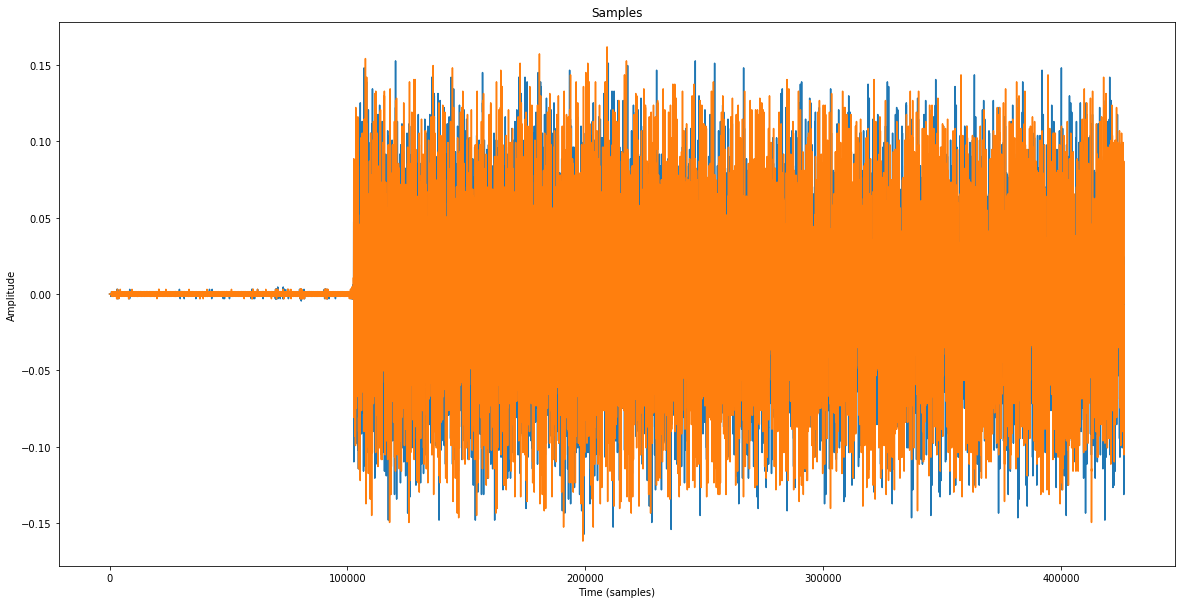

In [3]:
import numpy as np
import os
from scipy.io import wavfile

file_path = "/Users/Nil/devspace/Github_repos/alltheFSKs/iPhone_MFSK_Gpay_samples/iPhone_stereo_r_48khz_04022020_c3444867_translated_lpf.wav"

fs, data = wavfile.read(file_path)

# print(fs)

if(data.dtype == np.int16):
   data = data.astype(np.float)/2**16

number_of_complex_samples = len(data)
print(data.shape)
print(len(data))

re, im = np.hsplit(data, 2)

re = np.multiply(re.reshape(data.shape[0],), 1e+02)
im = np.multiply(im.reshape(data.shape[0],), 1e+02)

plt.figure(figsize=(20,10))
plt.plot((re))
plt.plot(im)
plt.ylabel("Amplitude")
plt.xlabel("Time (samples)")
plt.title("Samples")
plt.show()



<span style='font-family:Calibri'>
    <a id="code_construct"></a>

### Construct DSSS binary code sequence and code-signal
<font size='3'>

* We learnt from some OSINT, experimentation and guesstimation that the ultrasound signal transmitted by Google-pay, is a combination of 3 distinct signals. [Part1 of my medium post goes into the details of the kind of initial analysis](https://link.medium.com/WcttcAFxz5)
* In simple terms, the signal is made up of a data-signal, code-signal, a high-frequency carrier. The equations look something like this
    * **Transmitted signal** - 
              y(t) = sin(2piFt) * c(t) * d(t) where F = carrier freq, c(t) = code signal, d(t) = data signal
    * **Extracted signal** - frequency translation and filtering removes the carrier frequency and we're left with-
              b(t) = c(t) * d(t) where c(t) = code signal, d(t) = data signal
* As you can see from the above equation, we need to remove (or the right word is de-spread) the code-signal from our extracted signal to retrieve, our data signal. To do this we must first find the right code-sequence.
* A code sequence is just a pseudo-random binary sequence and we can generate these random sequences with what's called a LFSR (linear feedback shift register). 
* I was able to find the code-sequence used by google-pay using my implementation of a GLFSR (inlcuded in my github repo). G-pay uses a 127 bit binary sequence (bitmask is '120' and the initial seed value is '80')
* *I talk more about how I happen to find the right code-sequence in my **medium post** but essentially its just brute force.*
* Note -
    * The '-1's' in the code snippet below are actually 0's. We plot the binary code sequence with zeros flipped to '-1'.
    * The Github repo also contains a GLFSR implementation that you could use for other similar such experiments.
 

Text(0.5, 1.0, 'Sinc Interpolated DSSS Code Signal')

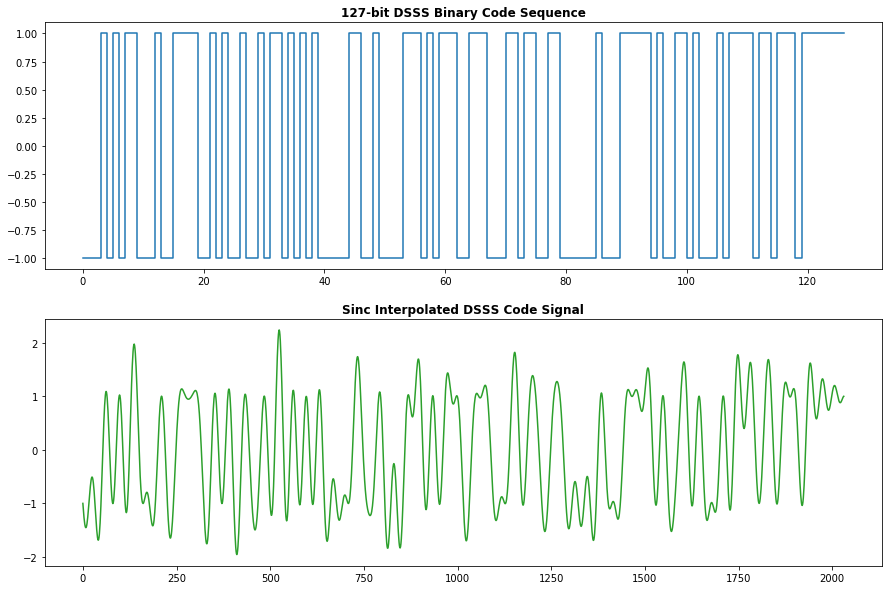

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import step, xlim, ylim, show
from scipy import signal

a = np.array([-1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1])

# code-sequence
b = np.tile(a, 1)
x = np.arange(0, 127)

# code-signal
us1 = upsample(b, 16) 

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,10))
ax1.step(x, b)
ax1.set_title('127-bit DSSS Binary Code Sequence', fontsize=12, fontweight="bold")
ax2.plot(us1, 'tab:green')
ax2.set_title('Sinc Interpolated DSSS Code Signal', fontsize=12, fontweight="bold")

<span style='font-family:Calibri'>
    <a id='sync'></a>

### DSSS code synchronization (i.e. cross-correlation of code-signal with our baseband signal)
<font size='3'>

* So, we've constructed our code-signal and extracted our baseband signal in the above steps 
* In this step, we attempt to correlate these 2 signals with each other. Correlation gives you the degree of similarity between signals and loosely speaking, you can think of it as a way to **look for the presence of one signal in another.**
* More specifically, we're going to cross-correlate the code-signal (we built) with the extracted signal (we sniffed off  air).
* Mathematically, correlation is a simple multiply and accumulate operation
* Cross-correlation -as the name suggestscross-correlation, we slide our code-signal forward by 1 sample against the received signal and correlate. 
* When yo do this, at some point our code-signal aligns with the received signal and at that point we get a nice spike. (See plot below) 
* **Note** -
    * Samples between correlation peaks are our symbols. You'll see why as we move forward. 


2032
422656
89.50084370678948
422656
8010.401024227159


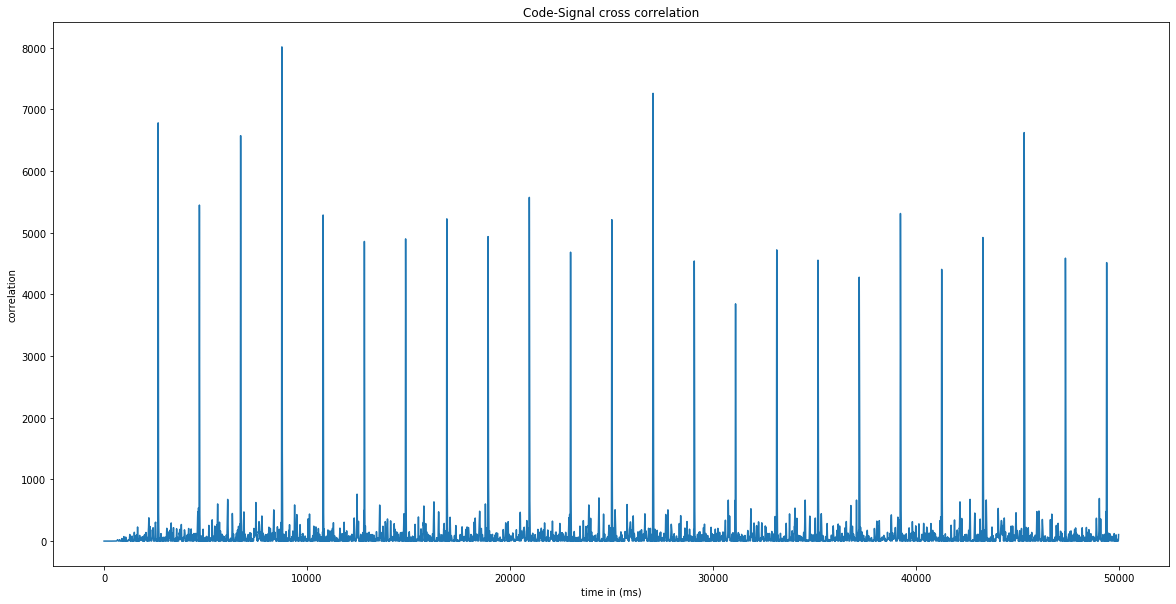

In [25]:

number_of_code_samples = len(us1)
print(len(us1))

correlation_magnitude_buffer = []
normalized_correlation_magnitude_buffer = []

# so that we dont overshoot when sliding the code signal forward
range_ = (int(number_of_complex_samples/number_of_code_samples)-1)*number_of_code_samples

for i in range(0, int(range_)):
    real_correl = np.correlate(us1, re[ i  : i + len(us1) ])[0]
    imag_correl = np.correlate(us1, im[ i  : i + len(us1) ])[0]

    correlation_magnitude = real_correl + imag_correl
    normalized_correl_magnitude = correlation_magnitude**2

    correlation_magnitude_buffer.append(correlation_magnitude)
    normalized_correlation_magnitude_buffer.append(normalized_correl_magnitude)
    
print(len(correlation_magnitude_buffer))
print(max(correlation_magnitude_buffer))
print(len(normalized_correlation_magnitude_buffer))
print(max(normalized_correlation_magnitude_buffer))

plt.figure(figsize=(20,10))
plt.plot((normalized_correlation_magnitude_buffer[100000:150000]))
plt.xlabel('time in (ms)')
plt.ylabel('correlation')
plt.title('Code-Signal cross correlation')
plt.show()

<span style='font-family:Calibri'>
    <a id='corr_peak'></a>
    
### Find the first largest correlation peak. 
<font size='3'>

* The first largest peak is at <b>sample number 102667</b> with a correlation peak of 6778.869459286602
* Note -This step still needs a human eye for now as the magnitude of correlation keeps changing with strength of received signal. So, you cant use a common threshold for 2 different audio recordings. 
* Normalization might help but I have *not thought of a way to automate this part yet.* 


In [29]:

h3 = sorted((v,i) for (v,i) in enumerate(normalized_correlation_magnitude_buffer) if (i > 6000) and ( v < 103000))
h4 = max([i for v,i in h3])

print(h3)
print(h4)

[(102663, 6005.358690015815), (102664, 6350.586618758092), (102665, 6600.014636510279), (102666, 6743.937839915293), (102667, 6778.869459286602), (102668, 6704.761345117046), (102669, 6527.362507124576), (102670, 6256.471331251961)]
6778.869459286602


<span style='font-family:Calibri'>
    <a id='code_track'></a>

### DSSS code tracking
<font size='3'>

* If we were to just pick the next 2032 samples after our first highest peak and then assume that's the next peak.
* And if we continue that process. 
* You'd notice that after a few thousand samples, the code-signal is no longer aligned at the highest correlation peak. 
* The reason - in a perfect world where interference nor noise exists, we should just be able to take the next len(code_signal) samples and be on our way but sadly that world doesn't exist.
* So, we have to account for this by checking for the next highest peak at every probable alignment boundary. 
* In our case, we look for the highest peak in the next probable alignment boundary (2032 + and -200 samples) 


In [30]:

i = 102667

peaks = []

while True:
    
    v = max(normalized_correlation_magnitude_buffer[i-200 : i+200])

    s, = np.where(np.isclose(normalized_correlation_magnitude_buffer, v, rtol = 1e-09)) 
    print('Index : {0}, Corr : {1}'.format(s, v))
    
    peaks.append([s[0],v])
    
    i = s[0] + 2032
            
    if i > data.shape[0]-2*2032:
        print('done')
        break


Index : [102667], Corr : 6778.869459286602
Index : [104699], Corr : 5446.378802750726
Index : [106731], Corr : 6571.969354420192
Index : [108764], Corr : 8010.401024227159
Index : [110796], Corr : 5285.6960930463565
Index : [112829], Corr : 4857.153234957815
Index : [114862], Corr : 4898.326299451809
Index : [116893], Corr : 5223.078269882726
Index : [118925], Corr : 4935.620500635903
Index : [120958], Corr : 5571.369020180033
Index : [122991], Corr : 4682.715513388305
Index : [125023], Corr : 5210.365945522694
Index : [127056], Corr : 7257.748610590412
Index : [129087], Corr : 4539.764305793891
Index : [131122], Corr : 3845.287572952842
Index : [133152], Corr : 4720.180969343814
Index : [135184], Corr : 4553.14830195491
Index : [137215], Corr : 4276.936784415769
Index : [139248], Corr : 5310.010049459368
Index : [141281], Corr : 4404.593242441256
Index : [143312], Corr : 4920.818472382275
Index : [145346], Corr : 6621.557248338889
Index : [147379], Corr : 4585.940462212541
Index : [14

<span style='font-family:Calibri'>
    <a id='data_despread_visualize'></a>

### Despreading the signal and visualising data via a Fourier transform 
<font size='3'>
        
    
* Now that we have aligned our code-signal with that of the received signal and identified the points of alignment (the correlated peaks). We can start despreading our signal.
* To de-spread the signal - we just multiply the code-signal (i.e. its 2032 samples) with a slice of the received signal i.e. **starting at a peak + the next 2032 samples** (let's just call this sequence **2032-peak samples or 1 symbol period** for short-hand)
* Despreading the signal reveals the actual data signal (i.e. the Multiple-FSK signal) that we're interested in.
* You might be thinking how do you know its MFSK - if you examine the despread signal's spectrum you'd see 2 things -
    * multiple frequency bursts and 
    * equi-distant tones/frequencies i.e. each tone is equidistant from the other by ~23.6 hertz (or our symbo_rate amount).
* The code snippet below plots an FFT (or in simpler terms a frequency domain plot) of a random slice of (i.e. one symbol) of the  recieved signal
* You do this a hundred times, you should be able to observe that pretty much every frequency plot has spikes in the 100 to 500 hertz range. 
* This probably means the actual MFSK signal probably uses this frequency range. (or bandwidth for data transmission)
    * If that's true, the exact type of **MFSK modulation must be 16-MFSK** i.e. $(500-100)/23.6 =~ 16.9$ 
    *  I rounded it to 16 (even number of tones)- *apparently its odd to have an odd number of frequencies in MFSK*

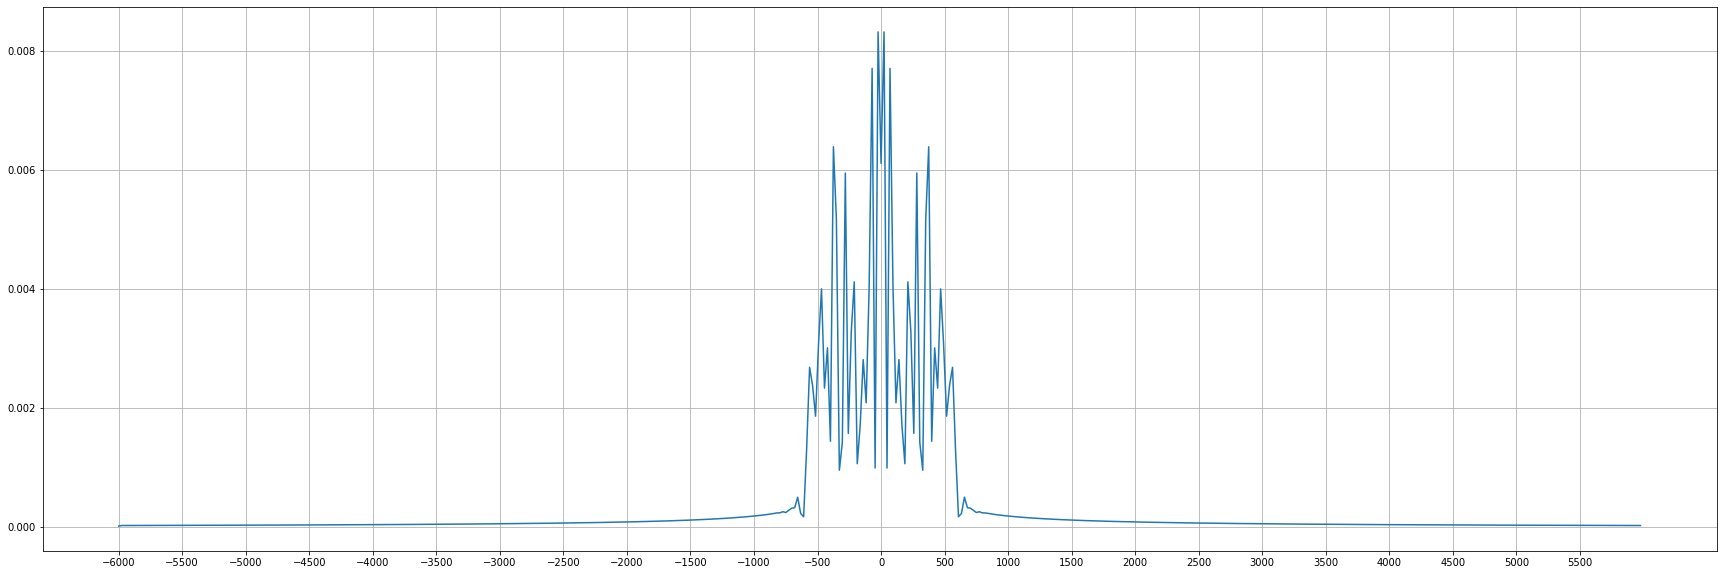

In [31]:

from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
from scipy.signal import butter,filtfilt


k = 421682                               # one of the peaks chosen randomly 
sample_rate = 48000
nyq_rate = sample_rate / 2.0
order = 9
cutoff = 560

despread_re = np.multiply(us1, re[ k  : k + len(us1) ])
despread_im = np.multiply(us1, im[ k  : k + len(us1) ])

# Apply a low pass filter with the cut-off at 560 hz seems to work well.
normal_cutoff = cutoff / nyq_rate
# Get the filter coefficients 
b, a = butter(order, normal_cutoff, btype='low', analog=False)
y = filtfilt(b, a, despread_re)

f = signal.resample(y, 512)

N = 512
# sample spacing
T = 1.0 / 12000.0
yf = fft(f)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

plt.figure(figsize=(30,10))
plt.plot(xf, 1.0/N * np.abs(yplot))
plt.xticks(np.arange(min(xf), max(xf)+1, 500.0))
plt.grid()
plt.show()


<span style='font-family:Calibri'>
    <a id='symbol_extract'></a>
    
### Symbol Extraction 
<font size='3'>
    
* So, we just guesstimated that the actual data signal is 16-MFSK modulated. Great, now all that's left is demoulating the MFSK signal. How would one demodulate MFSK? 
* I've previously done some basic reversing of BFSK or 2-FSK .... [read my blog on that here](https://link.medium.com/HgVjOJx6y5). 
* But it involves things like 'clock recovery' or offline analysis with tools like inspectrum (also that was just 2 frequencies, here we have 16). 
* In short, I couldn't find a usable pre-existing method/technique/tool to perform the MFSK demod. So stuck again -
* When you're stuck go back to basics. What do we know so far?
         * Our data signal is MFSK modulated. 
         * We know we have 16 frequencies/tones and 
         * We also know where each symbol starts and ends (i.e. our correlation peaks)
         * This is the moment where a light-bulb should go off.
* Each set of 2032-peak samples is a symbol. In terms of real physics, you can think of a symbol as a single burst of a particular frequency and we have 16 different frequencies which represent 16 different symbols. 
* Given the above, if we were to perform a Fourier transform (frequency domain plot) for each of the 2032-peak samples (or symbols), it should (in theory) give us the tones that fired for each corresponding symbol period.  
* Put simply, we take an FFT of the real and imaginary components separately for each symbol and look for the frequency/tone with the highest energy content. **That's our symbol.** The code-snippet below does exactly that.
        * It took me a while and numerous permutations and combinations to figure out that an FFT of the de-spreaded complex signal (i.e. real+imag together) is NOT the answer.
        * Instead independent FFTs of the real and imaginary components of the despread signal works. (Now I'm not entirely 100% sure why this is so but I do suspect a few things.)

* **We just figured out a way to do MFSK demod** (given you know where your symbols start/end). That's neat.


In [32]:

symbols_real = []
symbols_imag = []

base_freq = 100                     # This is in Hertz
symbol_rate = 23.6
num_tones = 16                      # This particular MFSK modulation contains 16 tones i.e. (500-100/23.6) =~ 16.95  
                                    # But its apparently odd to have an odd number of frequencies
                                    # So, I settled on '16'. Turns out that was right. 
tone_zero = int(round(base_freq/symbol_rate))       # the first or lowest tone in the sequence 

sample_rate = 48000
nyq_rate = sample_rate / 2.0
order = 9                          # This number is after experimentation. like Filter-design always is
cutoff = 560                       # same as above.

for index in iter(peaks):
    despread_re = np.multiply(us1, re[ index[0]  : index[0] + len(us1) ])
    despread_im = np.multiply(us1, im[ index[0]  : index[0] + len(us1) ])

    normal_cutoff = cutoff / nyq_rate
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    real = filtfilt(b, a, despread_re)
    
    normal_cutoff = cutoff / nyq_rate
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    imag = filtfilt(b, a, despread_im)

    
    fft_instant_real = np.fft.rfft(real)
    real_fft = fft_instant_real[tone_zero : tone_zero + num_tones]
        
    fft_instant_imag = np.fft.rfft(imag)
    imag_fft = fft_instant_imag[tone_zero : tone_zero + num_tones]
       

    currsymbol = np.argmax(np.absolute(real_fft))
    symbols_real.append(currsymbol)
    
    currsymbol = np.argmax(np.absolute(imag_fft))
    symbols_imag.append(currsymbol)


<span style='font-family:Calibri'>
    <a id='symbol_decode'></a>
    
### Symbol decoding 
<font size='3'>

* Finally, we have our symbols. Now just decode/map your symbols to actual data. In our case, that's the 8-digit token.
* You'd think this is the easy part. I mean how hard can it be? We've come this far. **But .... nope**
* I managed to find a patent in [google's patent repository](https://patents.google.com/patent/US9319096B1/en) that lays out the basic protocol for transmitting data. 
* It goes like this - start with a spacer symbol which is the highest tone/frequency (in our case its '15' cos computers count from 0) followed by a payload of 6 symbols and 1 parity symbol for error detection. 
* So, each transmitted token looks something like this

>> **[spacer + payload + parity]** - this sequence is called a token.

* Gpay includes a parity symbol or checksum of sorts for error detection. The parity symbol is the one that satifies the following condition

>> <font color=brown>$\sum{(spacer+payload+parity)}\;\%\;{16}\;==\;{0}$</font>

* But this is not the case i.e. I dont see this in my results with the right tokens. So, I'm now of the opinion that  google-pay may have changed its checksum or error detection method.
* To illustrate this in action, here's what a decoded sequence of symbols looks like. In the example below, the first sequence is the right one followed by 2 more sequences that are slightly off by one symbol (observe the 7 instead of an 8 at 'position 6'). The last but one sequence again is the right sequence.


In [33]:
tokens_real = []
tokens_imag = []

for i in range(0, len(symbols_real)-1):
    if symbols_real[i] == 15:
        token = symbols_real[i:i+8]
        tokens_real.append(token)
        
for i in range(0, len(symbols_imag)-1):
    if symbols_imag[i] == 15:
        token = symbols_imag[i:i+8]
        tokens_imag.append(token)
        
print(tokens_real)
print(tokens_imag)
    

[[15, 3, 4, 9, 0, 8, 3, 4], [15, 3, 4, 9, 0, 7, 3, 4], [15, 3, 4, 9, 0, 7, 3, 4], [15, 3, 4, 9, 0, 8, 3, 4], [15, 3, 4, 9, 0, 7, 3, 4]]
[]


<span style='font-family:Calibri'>
    <a id='token_generate'></a>

### Token generation
<font size='3'>
    
* As I couldn't figure out the checksum. I went for the next best thing.
* Approximation :)
* Instead of taking the sum % 16 == 0 as the patent document says, I approx with sum % 16 <=4 or >=13 and it works for the most part.
* But now - the token we're looking for is one of a few candidate tokens as you can see below.
    * The token we're looking for is **3444867**
    * Note -
         * For some android phones, especially older phones - we may need to change sum(tokens) expression to add 1 extra symbol (i.e. instead of *[i : i+8] symbols, we will need [i : i+9]*). So, there may be a few cases that may not fall into our approximation
         * Symbols need to be hex decoded. In this example, the extracted symbols are as follows- $[15, 0, 3, 4, 9, 0, 8, 3, 4]$. We remove the first and the last symbol from the sequence and hex decode the remaining (i.e. $0, 3, 4, 9, 0, 8, 3$) which gives us **3444867 in decimal**. That's our token.

* **That's it, we're done**. *A few more snippets at the bottom - for a  visual perspective.*


In [34]:
real_tokens = []
imag_tokens = []

for i in range(0, len(symbols_real)):
    if symbols_real[i] == 15:
        token = symbols_real[i:i+8]
        checksum = np.sum(token) % 16
        if checksum <= 4 or checksum >= 13 :
            q = (''.join([format(symbol, 'x') for symbol in token[1:7]]))
#             print(q)
#             print(int(q, 16))
            real_tokens.append(int(q, 16))

for i in range(0, len(symbols_imag)):
    if symbols_imag[i] == 15:
        token = symbols_imag[i:i+8]
        checksum = np.sum(token) % 16
        if checksum <= 4 or checksum >= 13 :
            q = (''.join([format(symbol, 'x') for symbol in token[1:7]]))
#             print(q)
#             print(int(q, 16))
            imag_tokens.append(int(q, 16))
            
def remove_duplicates(token_list): 
    final_list = [] 
    for num in token_list: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list 

print(remove_duplicates(real_tokens))
print(remove_duplicates(imag_tokens))

[3444867, 3444851]
[]


<span style='font-family:Calibri'>
    <a id='miscel'></a>

# Miscellaneous

<span style='font-family:Calibri'>
    <a id='compare_spread_vs_despread'></a>

### DSSS - Visual comparison of spread Vs de-spread signals 
<font size='3'>

* To get a better visual perspective, here are some plots. 
* The first one is a single pure tone/frequency.
* The second one is mixed with our code-signal 
* The third is the unmixed version of the same signal. See, how there's some symmetry in this one. In real life, this is not the case as you'll have noise to deal with.

2032
2032


Text(0.5, 1.0, 'Unmixed Wave')

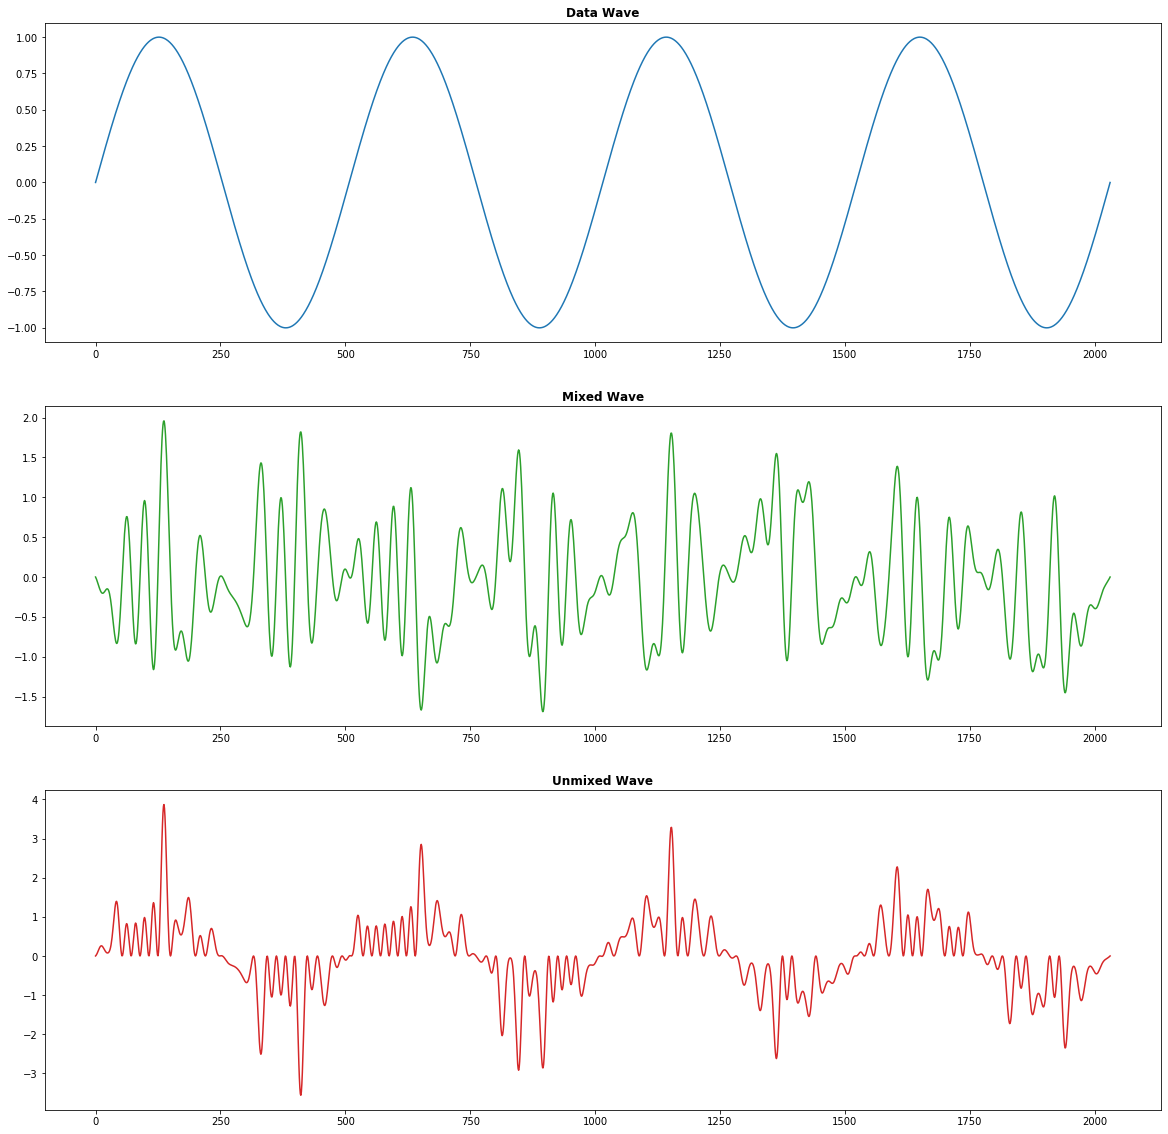

In [42]:
x = np.linspace(0, 42.33, 2032)
y = np.sin(2 * np.pi * ((4+0)/42.33) * x)

print(len(x))
print(len(y))

z = np.multiply(y, us1)

mot = np.multiply(z, us1)

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20,20))
# fig.suptitle('Vertically stacked subplots')
ax1.plot(y)
ax1.set_title('Data Wave', fontsize=12, fontweight="bold")
ax2.plot(z, 'tab:green')
ax2.set_title('Mixed Wave', fontsize=12, fontweight="bold")
ax3.plot(mot, 'tab:red')
ax3.set_title('Unmixed Wave', fontsize=12, fontweight="bold")

<span style='font-family:Calibri'>
    <a id='fft_view_spread_vs_despread'></a>

### DSSS - FFT plot of spread Vs despread signals
<font size='3'>

* Now lets take an FFT of the mixed and unmixed waves to see what we get
* You can clearly see 2 distinct spikes in the Unmixed FFT. That's the original tone that was mixed in with the code-signal.
* And a completely different FFT plot for the Mixed FFT. Here the bandwidth usage (amount of spectrum in use) is much more than the one above. That's DSSS at-play. 
* DSSS is very good at **multipath and interference rejection** but it comes at a price. You need a quite a bit more spectrum bandwidth (relative to the original signal). 

Text(0.5, 1.0, 'Fourier transform of Spread/Mixed wave')

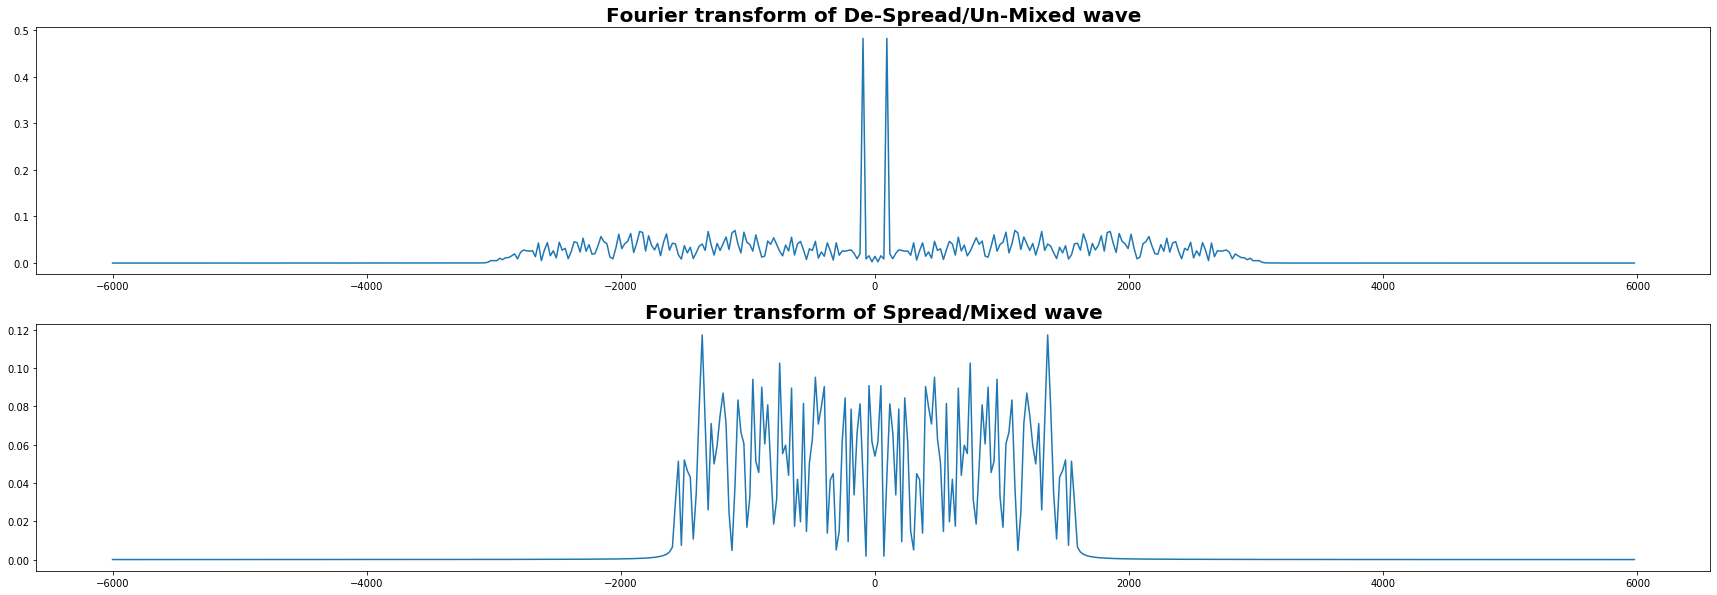

In [41]:
f = signal.resample(mot, 512)

N = 512
# sample spacing
T = 1.0 / 12000.0
yf = fft(f)
xf = fftfreq(N, T)
xf = fftshift(xf)
yplot = fftshift(yf)

f1 = signal.resample(z, 512)

N = 512
# sample spacing
T = 1.0 / 12000.0
yf1 = fft(f1)
xf1 = fftfreq(N, T)
xf1 = fftshift(xf1)
yplot1 = fftshift(yf1)

fig, (ax1, ax2) = plt.subplots(2, figsize=(30,10))
# fig.suptitle('Vertically stacked subplots')
ax1.plot(xf, 1.0/N * np.abs(yplot))
ax1.set_title('Fourier transform of De-Spread/Un-Mixed wave', fontsize=20, fontweight="bold")
ax2.plot(xf1, 1.0/N * np.abs(yplot1))
ax2.set_title('Fourier transform of Spread/Mixed wave', fontsize=20, fontweight="bold")